# **Tutorial 4** - Geophysics (Seismology)

In this tutorial we will learn how to

 1. Prepare **gridded data**: [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.xyz2grd.html)
 2. Create a **contour map**: [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html)
 3. Create a **profile plot**: [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) and [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html)

-----
This tutorial is part of the AGU2024 annual meeting GMT/PyGMT pre-conference workshop (PREWS9) **Mastering Geospatial Visualizations with GMT/PyGMT**
- Conference: https://agu.confex.com/agu/agu24/meetingapp.cgi/Session/226736
- GitHub: https://github.com/GenericMappingTools/agu24workshop
- Website: https://www.generic-mapping-tools.org/agu24workshop
- Recommended version: PyGMT v0.13.0 with GMT 6.5.0

## 0. General stuff

Import the required packages. Besides [`PyGMT`](https://www.pygmt.org/v0.13.0) we also use [`NumPy`](https://numpy.org/doc/stable/) and [`pandas`](https://pandas.pydata.org/).

In [1]:
import pygmt
import numpy as np
import pandas as pd 

# Use a resolution of only 150 dpi for the images within the Jupyter nootebook, to keep the file small
img_dpi = 150

## 1. Prepare gridded data: [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.xyz2grd.html)

Sometimes, spatial (regional or global) data is provided as tabular data (.txt or .csv files) containing x, y, and z columns.

In [2]:
# Reading file
data = np.loadtxt("south_america_topography_05m.txt")

print(type(data))
data

<class 'numpy.ndarray'>


array([[  -90.        ,     0.        , -1033.5       ],
       [  -89.91666667,     0.        , -1132.5       ],
       [  -89.83333333,     0.        , -1298.        ],
       ...,
       [  -60.16666667,   -40.        ,   -50.        ],
       [  -60.08333333,   -40.        ,   -52.        ],
       [  -60.        ,   -40.        ,   -54.        ]])

We have to convert the `numpy.ndarray` to a GMT-ready grid via [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.xyz2grd.html). Therefore, you need to provide:

1. `data` or `x`, `y`, `z`: Input text file. Importantly, if you use `data`, the columns order must be longitude, latitude, and data. Otherwise, you should use `x`, `y`, and `z` to individually define the dataset. 
2. `region`: Specifies the grid's geographical region in the form `[lon_min, lon_max, lat_min, lat_max]`.
3. `spacing`: Grid spacing for the output grid. In our case, the spacing of original dataset is `5m`, we do not interpolate to better resolution, otherwise, it might cause data distortion. 

In [3]:
region = [-90, -60, -40, 0]  

grid = pygmt.xyz2grd(data=data, spacing="5m", region=region)

We can get some information about the grid using [`pygmt.grdinfo`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdinfo.html):

In [4]:
print(pygmt.grdinfo(grid))

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Geographic grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -90 x_max: -60 x_inc: 0.0833333333333 (5 min) name: x n_columns: 361
: y_min: -40 y_max: 0 y_inc: 0.0833333333333 (5 min) name: y n_rows: 481
: v_min: -7816.5 v_max: 5798.5 name: z
: scale_factor: 1 add_offset: 0
: format: classic
: Default CPT: 



In PyGMT, the grid is stored in an Xarray.DataArray:

In [5]:
grid

<xarray.DataArray 'z' (lat: 481, lon: 361)> Size: 1MB
array([[-3470.5, -3474. , -3455.5, ...,   -50. ,   -52. ,   -54. ],
       [-3447.5, -3438.5, -3436. , ...,   -46. ,   -50.5,   -51. ],
       [-3440.5, -3419.5, -3419. , ...,   -44.5,   -49. ,   -51. ],
       ...,
       [ -970. , -1083. , -1261.5, ...,   114. ,   126.5,   129. ],
       [ -959. , -1044. , -1204. , ...,   110.5,   124.5,   146. ],
       [-1033.5, -1132.5, -1298. , ...,   108. ,   117. ,   141. ]])
Coordinates:
  * lat      (lat) float64 4kB -40.0 -39.92 -39.83 ... -0.1667 -0.08333 0.0
  * lon      (lon) float64 3kB -90.0 -89.92 -89.83 ... -60.17 -60.08 -60.0
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt xyz2grd @GMTAPI@-S-I-D-M-T-N-000000 -G@GMTAPI@-S-O-G-G...
    description:   
    long_name:     z
    actual_range:  [nan nan]

## 2. Create a contour map: [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html)
To plot grids or images as contour lines you can use [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html):

You need to define:
1. `grid`: Access the remote datasets or providing your dataset as ``xarray.DataArray``
2. `level`: Specify the contour intervals to generate; for example, value of 1000 means plotting contour lines at every 1000 m.
3. `annotation`: Annotate contour levels
4. `limit`: Draw contours below low or above high, e.g., [-4000, 0] means drawing contour lines below sea level and above -4000 m.

Before we plot the grid as contour lines, we plot the grid with color-coding using [`pygmt.Figure.grdimage`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdimage.html).

In [6]:
fig = pygmt.Figure()
fig.basemap(projection="M10c", region=region, frame="a10f5")

pygmt.makecpt(cmap="oleron", series=[-7000, 7000], transparency=30)
fig.colorbar(frame=["xa2000f1000+lElevation", "y+lm"])

fig.grdimage(grid=grid, cmap=True, transparency=30)

fig.grdcontour(grid=grid, annotation=2000, levels=1000, limit=[-4000, 0], pen="0.5p,white")

# fig.show(dpi=img_dpi)

## 3. Create a profile plot: [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) and [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html)

[`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) is designed to sample points along a great circle, a straight line, or across specified distance.

In our case, we will create a profile by point-to-point. Therefore you need to define: 
1. `center` and `endpoint`: Specify the start and end coordinates of the profile
2. `generate`: Distance interval of each point. e.g., `10` means points are generated every 10 degrees along the profile. 
3. `unit` (option): By default, `unit=False`, the distances of points along the profile are measured in degrees. When `unit=True` is used, it specifies that the distances are generated in kilometers. 

In [7]:
# Choose a survey line
start_x = -85  # Longitude in degrees East
start_y = -20  # Latitude in degrees North
end_x = -62
end_y= -20

# Plot the survey line
fig.plot(x=[start_x, end_x],  y=[start_y, end_y], pen="1p,red")

fig.text(
    x=[start_x, end_x], 
    y=[start_y, end_y],
    text=["A", "A'"],
    offset="0c/0.3c", 
    font="10p,1,white",
    fill="red",
)

track_df = pygmt.project(
    center=[start_x, start_y], 
    endpoint=[end_x, end_y], 
    # Output data in steps of 1 km with setting unit=True
    generate="1", 
    unit=True,
)

# fig.show(dpi=img_dpi)

In [8]:
track_df.head()

,r,s,p
0,-85.000000,-20.000000,0.0
1,-84.990453,-20.000624,1.0
2,-84.980905,-20.001248,2.0
3,-84.971358,-20.001871,3.0
4,-84.961810,-20.002493,4.0


**NOTE**: the output format is `pandas.DataFrame`, and **r** and **s** together provide the geographic coordinates (longitude, latitude) of each point along the track, while **p** gives the cumulative distance along the profile up to each point. 


Then, we use [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html) to sample topographic (or other grid-based data) values along a profile that you generated using [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html). This allows you to retrieve data from a grid file along a specified path. 

Therefore, you need to provide:

1. `grid`: Specifies the grid file (e.g., a topographic grid) from which data will be sampled
2. `points`: Provides the coordinates of the profile points
3. `newcolname`: Name for the new column with sampled values

In [9]:
# Extract the elevation at the generated points from the downloaded grid
# and add it as new column "elevation" to the pandas.DataFrame
track_df = pygmt.grdtrack(grid=grid, points=track_df, newcolname="elevation")

In [10]:
track_df.head()

,r,s,p,elevation
0,-85.000000,-20.000000,0.0,-4440.500000
1,-84.990453,-20.000624,1.0,-4445.130540
2,-84.980905,-20.001248,2.0,-4450.944209
3,-84.971358,-20.001871,3.0,-4457.558040
4,-84.961810,-20.002493,4.0,-4464.581447


**Note**: the new column is **elevation** to indicate the elevation variation along the track

Now, we add additional different size panel to visualize the topography. 
The first thing is observe the minimum and maximum of data. 


In [11]:
print(min(track_df["elevation"]), max(track_df["elevation"]))

-7319.553238186641 4422.575285314314


Then, using [`figure.shift_origin`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.shift_origin.html) to shift [`figure.basemap`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.basemap.html) to avoid original figure. 

In [12]:
fig.shift_origin(yshift="h+1.5c")

fig.basemap(
    region=[0, max(track_df["p"]), -7500, 5000],
    # Cartesian projection with a width of 12 centimeters and a height of 3 centimeters
    projection="X10c/3c",
    frame=["WSrt", "xa500f250+lDistance / km", "ya2500+lElevation / m"],
)

fig.text(
    x=[0, max(track_df["p"])],
    y=[5000, 5000],
    text=["A", "A'"],
    offset="0c/0.3c",
    no_clip=True,  # Do not clip text that fall outside the plot bounds
    font="12p"
)

# fig.show(dpi=img_dpi)

Coloring the land in lightgray and the ocean in lightblue according to the profile variation

In [13]:
# Plot water masses
fig.plot(
    x=[0, max(track_df["p"])],
    y=[0, 0],
    fill="lightblue",  # Fill the polygon in "lightblue"
    close="+y-7500",  # Force closed polygon
)

# Plot elevation along the survey line
fig.plot(
    x=track_df["p"],
    y=track_df["elevation"],
    fill="lightgray",  # Fill the polygon in "lightgray"
    # Draw a 1-point thick, black, solid outline
    pen="1p,black,solid",
    close="+y-7500",  # Force closed polygon
)

# fig.show(dpi=img_dpi)

## 4. Add additional features

own ideas here! Here are a few ideas what you can try:
Additionally, you can add additional features on top of the geographic map. Feel free to include your own ideas here! Here are a few ideas what you can try:

- **Plot the seismicity**: See subsection 4.1
- **Highlight a specific earthquake as beachball**: See subsection 4.2
- **Mark the subduction zone**: Use a so-called line front to indicate the fault, use the Gallery example [Line fronts](https://www.pygmt.org/v0.13.0/gallery/lines/linefronts.html) for an orientation
- **Include the plate motion**: Use an arrow to indicate direction and speed; use the Gallery example [Cartesian, circular, and geographic vectors](https://www.pygmt.org/v0.13.0/gallery/lines/vector_styles.html) for an orientation

In [14]:
# Move plotting origin back to the geographic map at the top
fig.shift_origin(yshift="-16c")  # Manually adjusted

# Use the same projection and region we have used at the beginning for the geographic map
fig.basemap(projection="M10c", region=region, frame="rltb")

### 4.1 Add seismicity

We provide data for the seismicity between 2022-01-01 and 2023-01-01 as a CSV file within this repository or tutorial. These data was retrieved via [ObsPy](https://docs.obspy.org/) using the `client.get_events` function:

> t1 = UTCDateTime("2022-01-01"); t2 = UTCDateTime("2023-01-01")
> 
> cat = client.get_events(starttime=t1, endtime=t2, minlatitude=-40, maxlatitude=0, minlongitude=-90, maxlongitude=-60)

First, we read the data into a `pandas.DataFrame` and have a look at the data.

In [15]:
df = pd.read_csv("seismicity_2022.csv")
df.head()

,time,lon,lat,depth,mag
0,2022-12-31T23:04:12.784000Z,-69.6800,-16.5378,196.743,4.9
1,2022-12-31T12:47:57.842000Z,-71.5625,-32.2686,48.300,4.5
2,2022-12-31T03:31:43.830000Z,-68.8969,-23.1036,96.224,5.1
3,2022-12-31T00:43:57.999000Z,-77.7617,-1.7451,182.543,4.3
4,2022-12-30T22:35:25.866000Z,-67.1397,-24.0267,232.941,4.5


Explore the dataset. Get the value ranges of the hypocentral depth and magnitude.

In [16]:
# Your code (:

Now we split the dataset into two datasets based on the magnitude. Feel free to try different limits or build other subset!

In [17]:
lim_mag = 6

df_low_mag = df[df["mag"] < lim_mag]
df_high_mag = df[df["mag"] >= lim_mag]

Now you can plot the earthquakes of the two datasets on top of our map, e.g., using circles for the events with lower and stars for the events with higher magnitude. Additionally, you can add color- and size-coding to include epicentral distance and magnitude of the earthquakes. Take a look at what you have learned in Tutorial 2 🙂 and the PyGMT Tutorial [Plotting data points](https://www.pygmt.org/v0.13.0/tutorials/basics/plot.html) as an orientation.

In [18]:
# Your code (:

### 4.2 Add a beachball 

A specific earthquakes can be plotted as a beachballs to represent the focal mechanism. Here, we look at the Esmeraldas earthquake on 2022/03/27 at 04:28:12 (UTC) as an example. The data were retrieved from USGS.

First we, store the focal mechanism parameters in a dictionary based on the Aki & Richards convention:

In [19]:
focal_mechanism = {"strike": 116, "dip": 80, "rake": 74, "magnitude": 5.8}

Plot the focal mechanism of this earthquake as a beachball on top of the map. Therefore, we pass the focal mechanism data to the `spec` parameter
of [`pygmt.Figure.meca`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.meca.html). In addition, you have to provide scale, event location, and event depth.

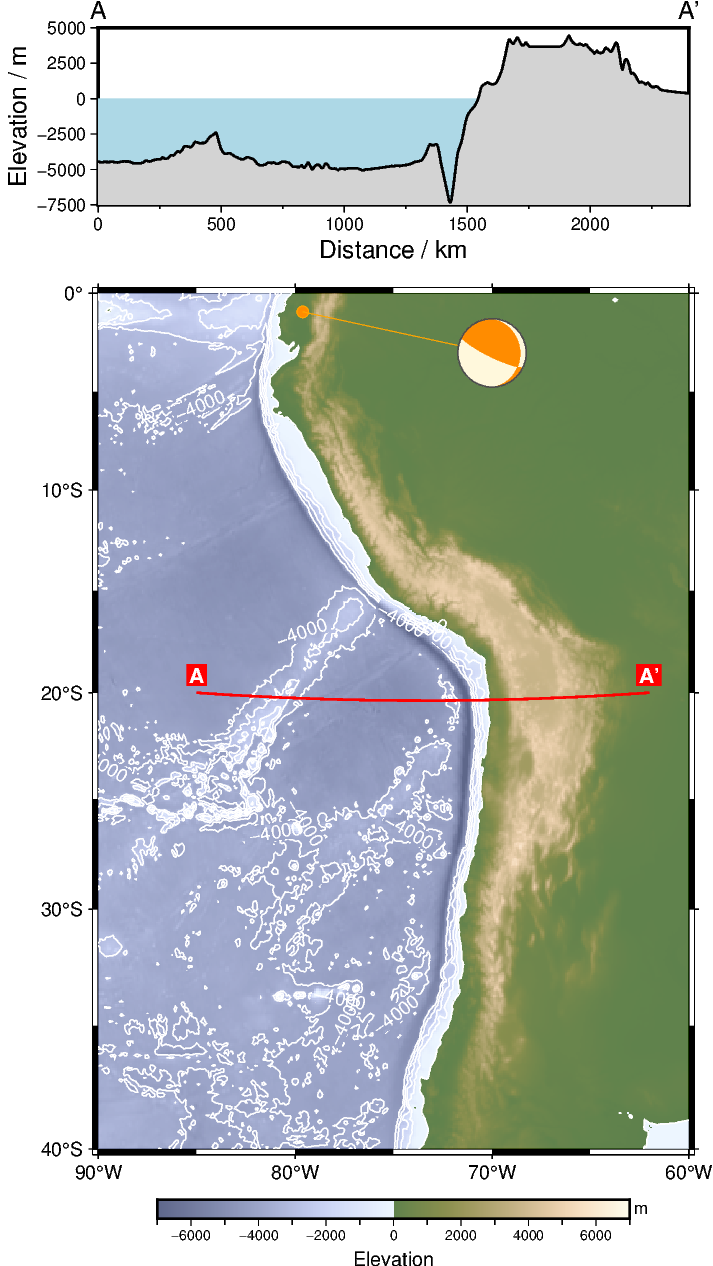

In [20]:
fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=-79.611,  # event location
    latitude=-0.904,
    depth=19,  # in kilometers
    # Fill compressive quadrants with color "darkorange" [Default is "black"]
    compressionfill="darkorange",
    # Fill extensive quadrants with color "cornsilk" [Default is "white"]
    extensionfill="cornsilk",
    # Draw a 0.5-points thick, darkgray ("gray30") solid outline via the pen parameter
    # [Default is "0.25p,black,solid"]
    pen="0.5p,gray30,solid",
    # Shift plotting location from event location
    plot_longitude=-70,
    plot_latitude=-3,
    # Add a connection line between the plotting and event locations
    offset="+p0.1p,orange+s0.2c",
)
 
fig.show(dpi=img_dpi)

## 5. Additional comments

Some helpful and interesting aspects:

- Use suitable colormaps for your data: [**Scientific colourmaps by Fabio Crameri**](https://www.fabiocrameri.ch/colourmaps/), see also the publications [Crameri et al. (2024)](https://doi.org/10.1002/cpz1.1126) and [Crameri et al. (2020)](https://doi.org/10.1038/s41467-020-19160-7)

## 6. Orientation / suggestion for 4.1

Below you find a rough code shipset for plotting the subsets of the earthquake dataset in section 4.1. Note the logarithmic scaling of size of the symbols as the size is referring to the magnitude of the earthquakes.

In [21]:
pygmt.makecpt(cmap="acton", series=[0, 500], reverse=True)

fig.plot(
    x=df_low_mag["lon"], 
    y=df_low_mag["lat"], 
    style="cc",  # Plot circles (fist "c") in centimeters (second "c")
    size=np.log10(df_low_mag["mag"])/4, 
    fill=df_low_mag["depth"],
    cmap=True,
    pen="0.1p,black",
)

fig.plot(
    x=df_high_mag["lon"], 
    y=df_high_mag["lat"], 
    style="ac",  # Plot stars ("a") in centimeters ("c")
    size=np.log10(df_high_mag["mag"]), 
    fill=df_high_mag["depth"],
    cmap=True,
    pen="0.5p,black",
)

fig.colorbar(
    position="x0.5c/0.5c+w4.5c/0.25c+v+mc+ef0.2c",
    frame=["a100f50+lHypocentral depth", "y+lkm"],
    box="+gwhite@30",
)

# fig.show(dpi=img_dpi)